In [ ]:
# Created on April 2024 by Go Reply (based on Google's resources)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Document AI for Data Extraction

### Objective

This notebook explores the use of Document AI for data extraction.
It uses the following Google Cloud ML services:
- Document AI API

### Costs

Billable components of Google Cloud:

* Document AI
* Cloud Storage

Estimated costs to be calculated using: the [Pricing
Calculator](https://cloud.google.com/products/calculator/)

*For more details on [Document AI
pricing](https://cloud.google.com/document-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing)

# Document AI Console Experimentation

First, lets test Document AI in the console:

*Start by enabling the Document AI API


Select a document for the following sections ( feel free to use one of the provided documents from the bucket: ./documents/ )


### 1. Create a Custom Processor in Document AI

# Document AI for Data Extraction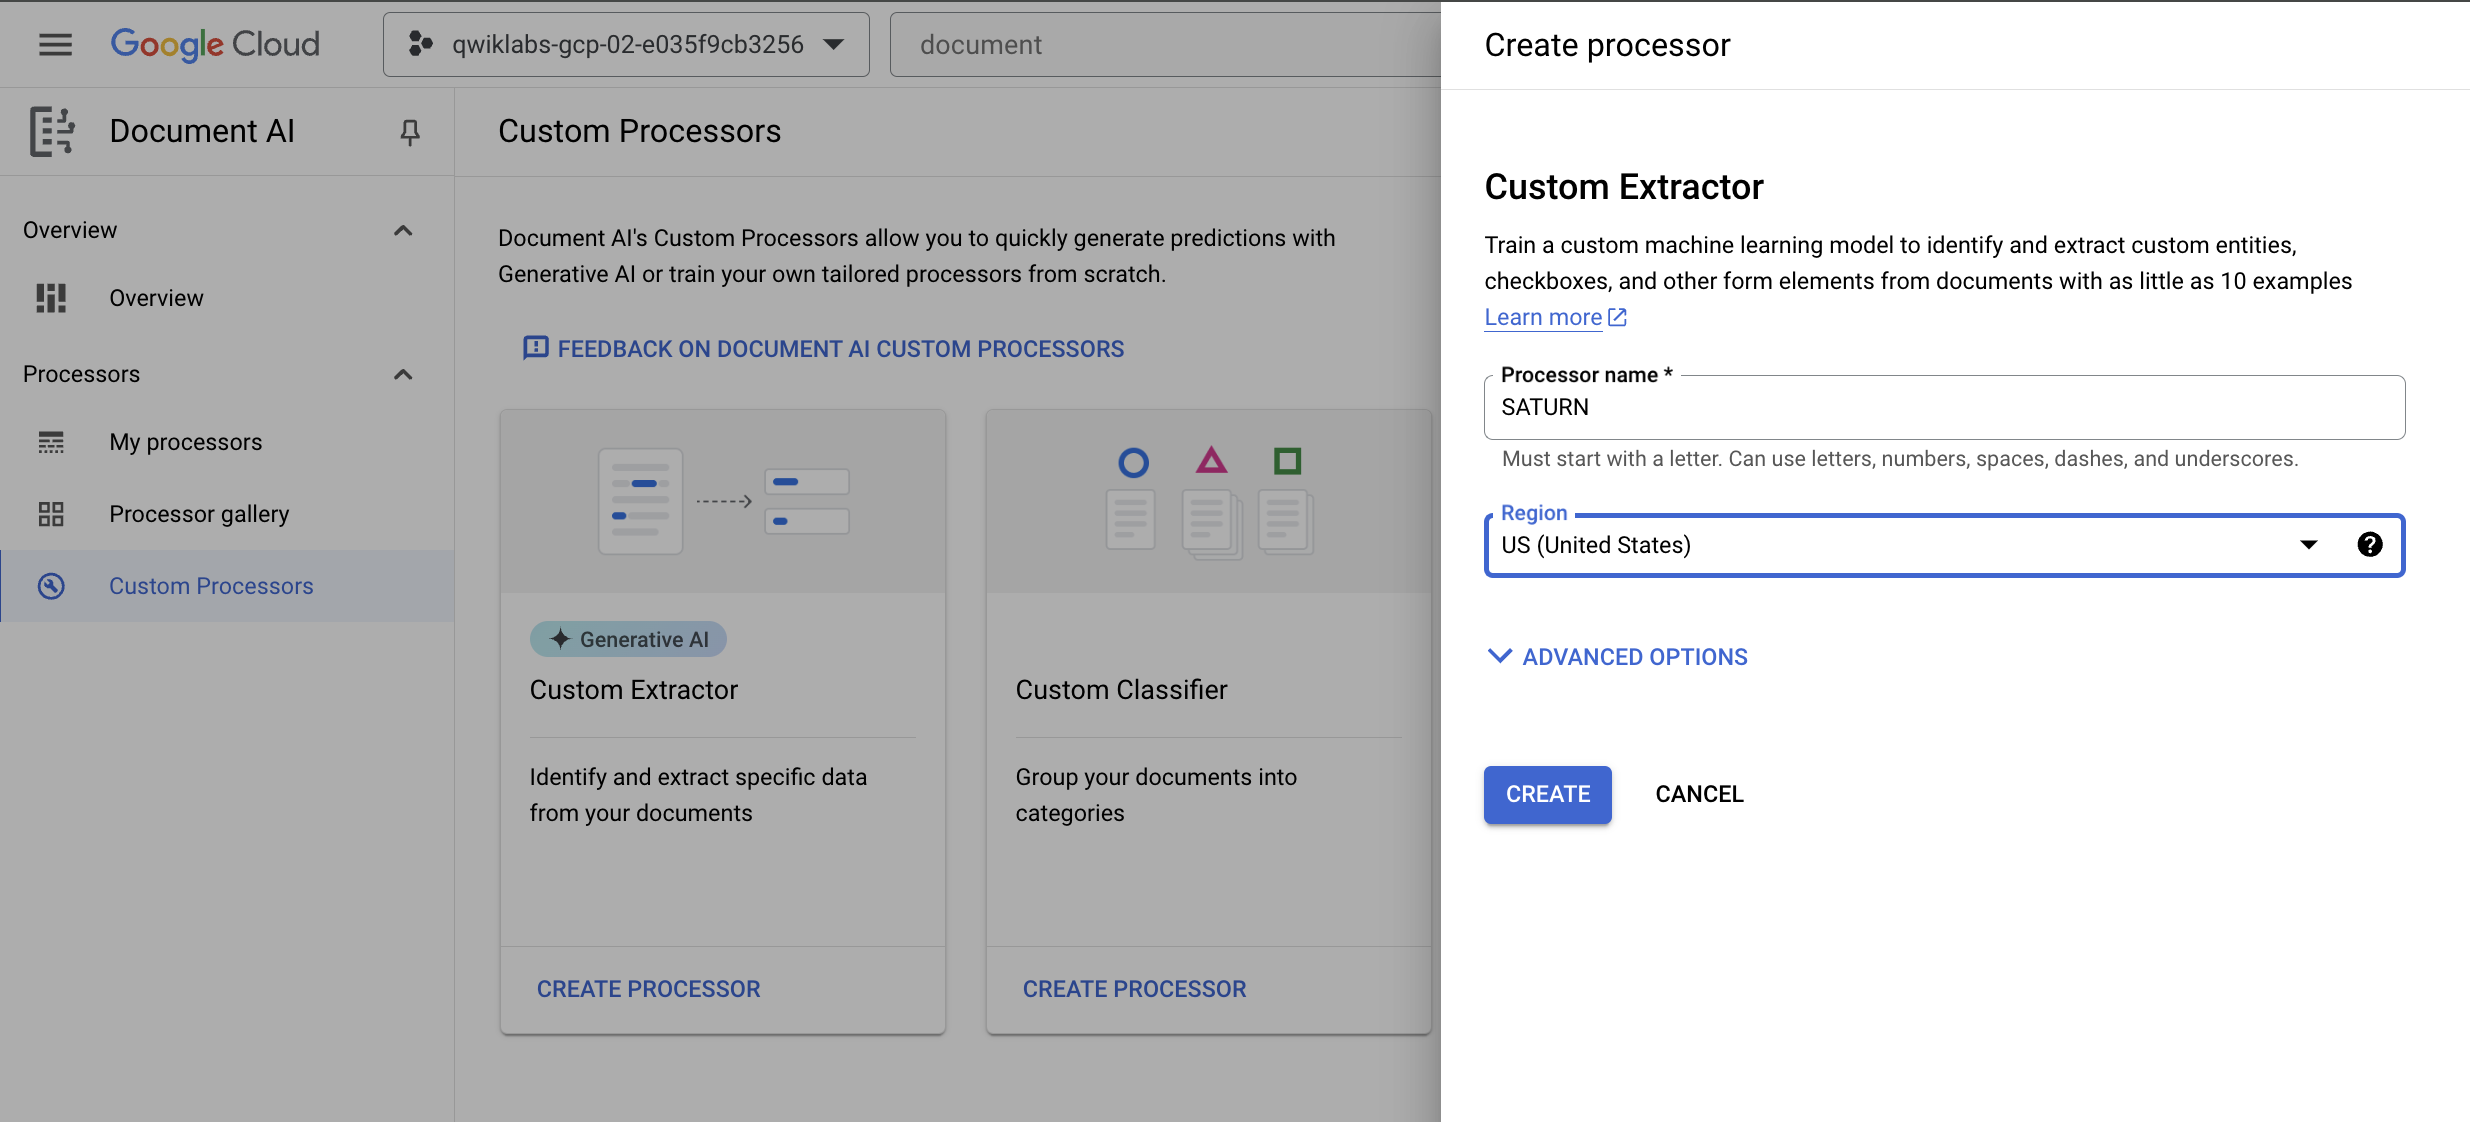

## 2. Set some fields relevant to your document

- Metadata Fields (Date, Title, Entity name, Contact, etc...)
- Unstructured text data (Clauses, Document Sections, etc...)
- Tabular data (Costs, Timelines, etc...)

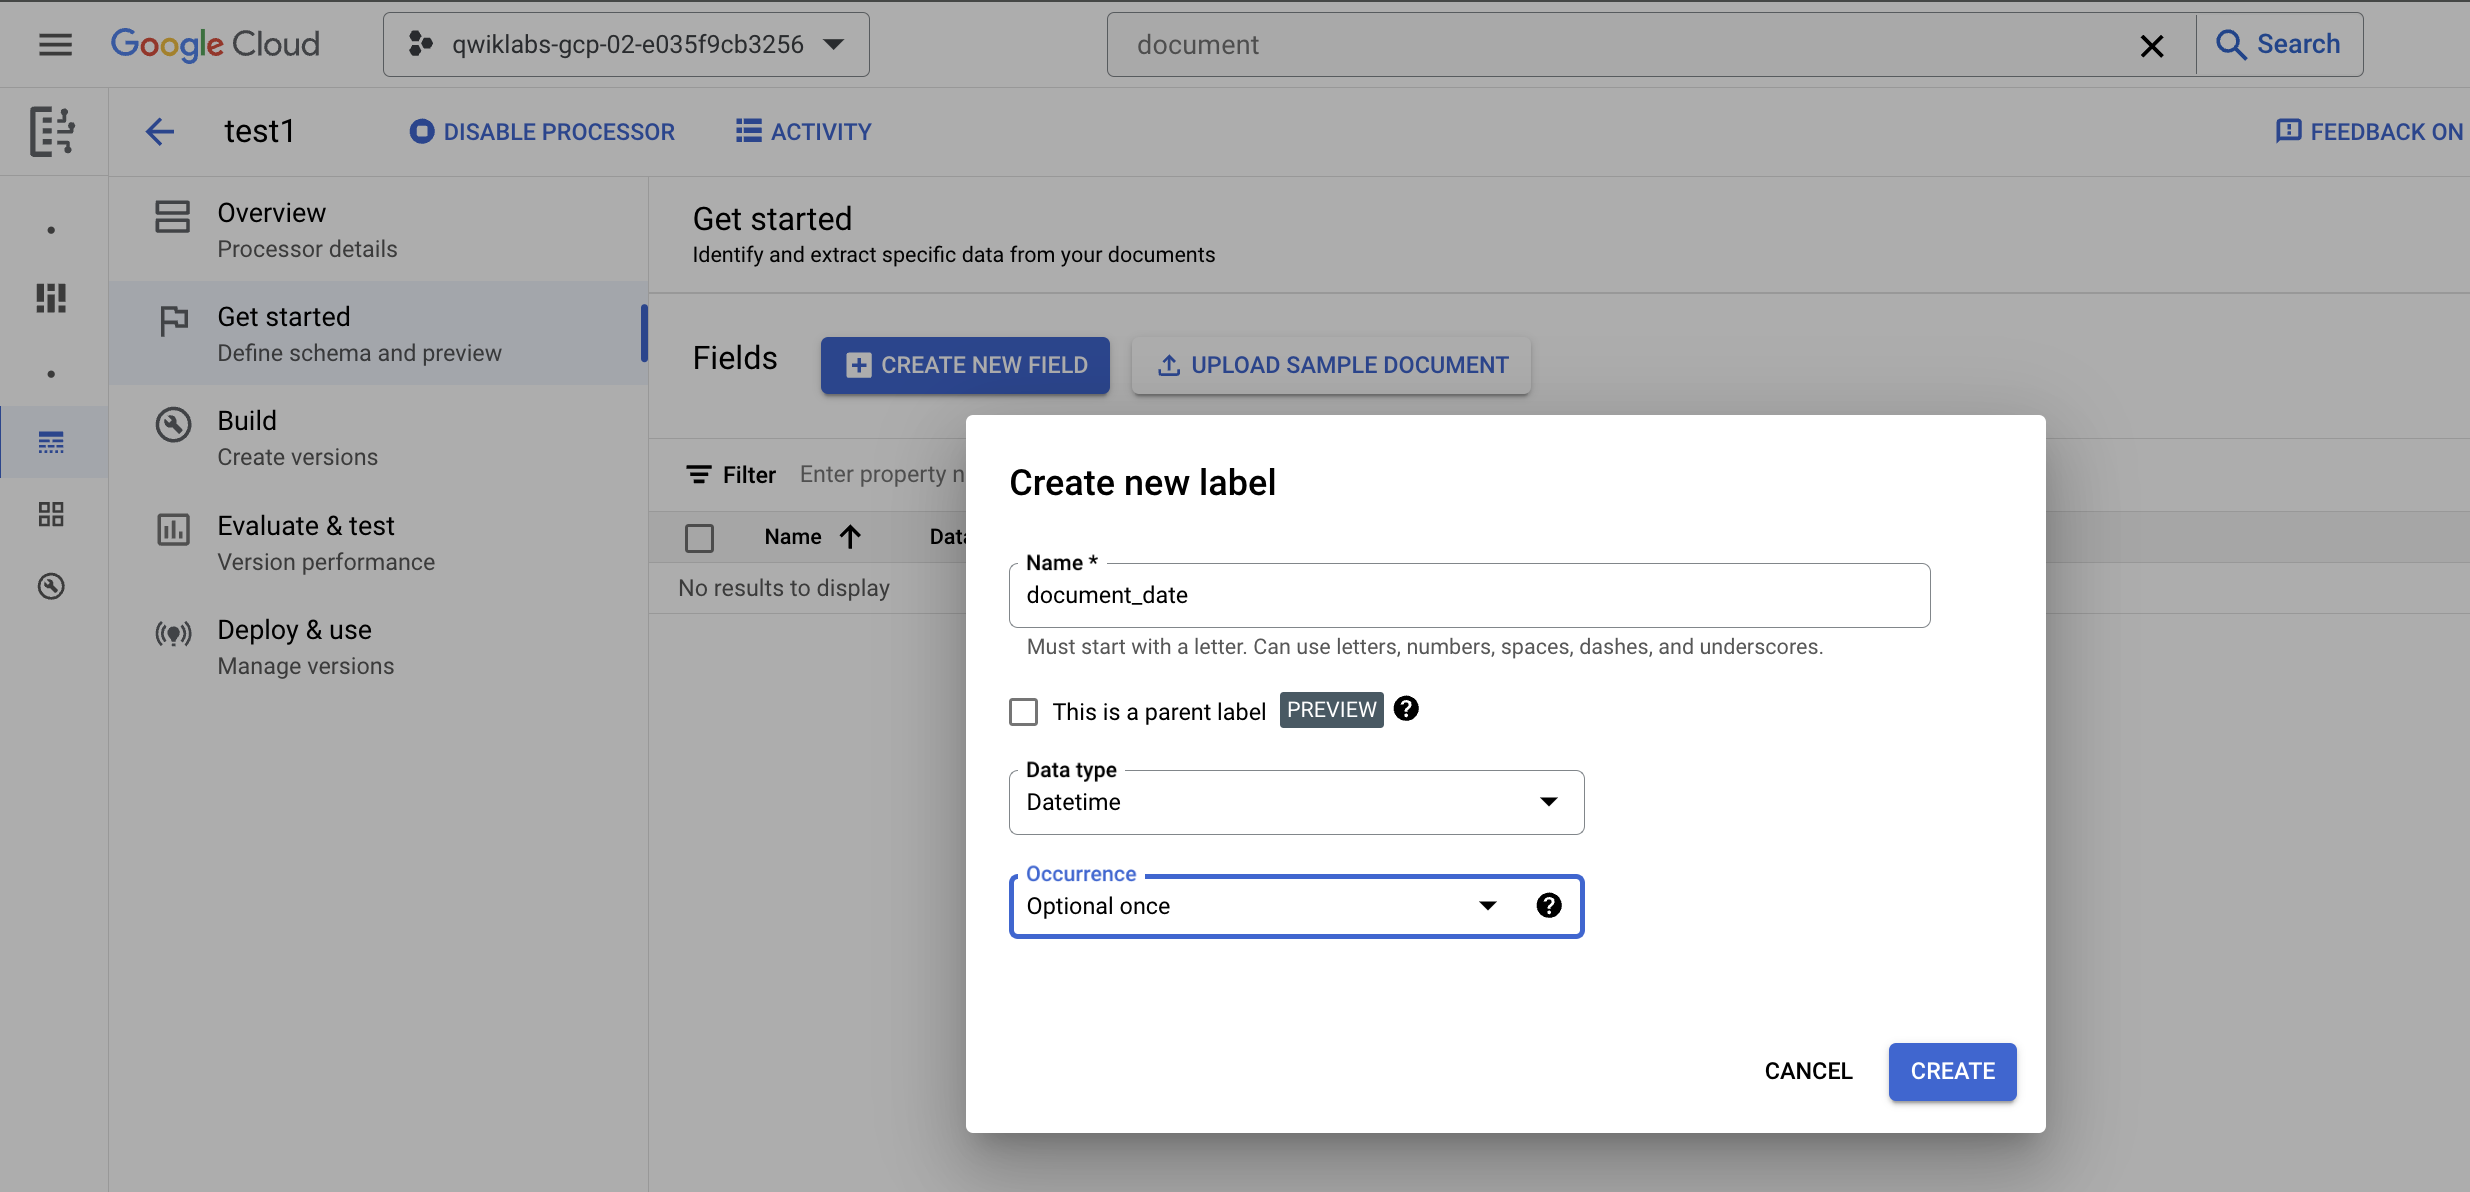

## Upload your sample document & check the results

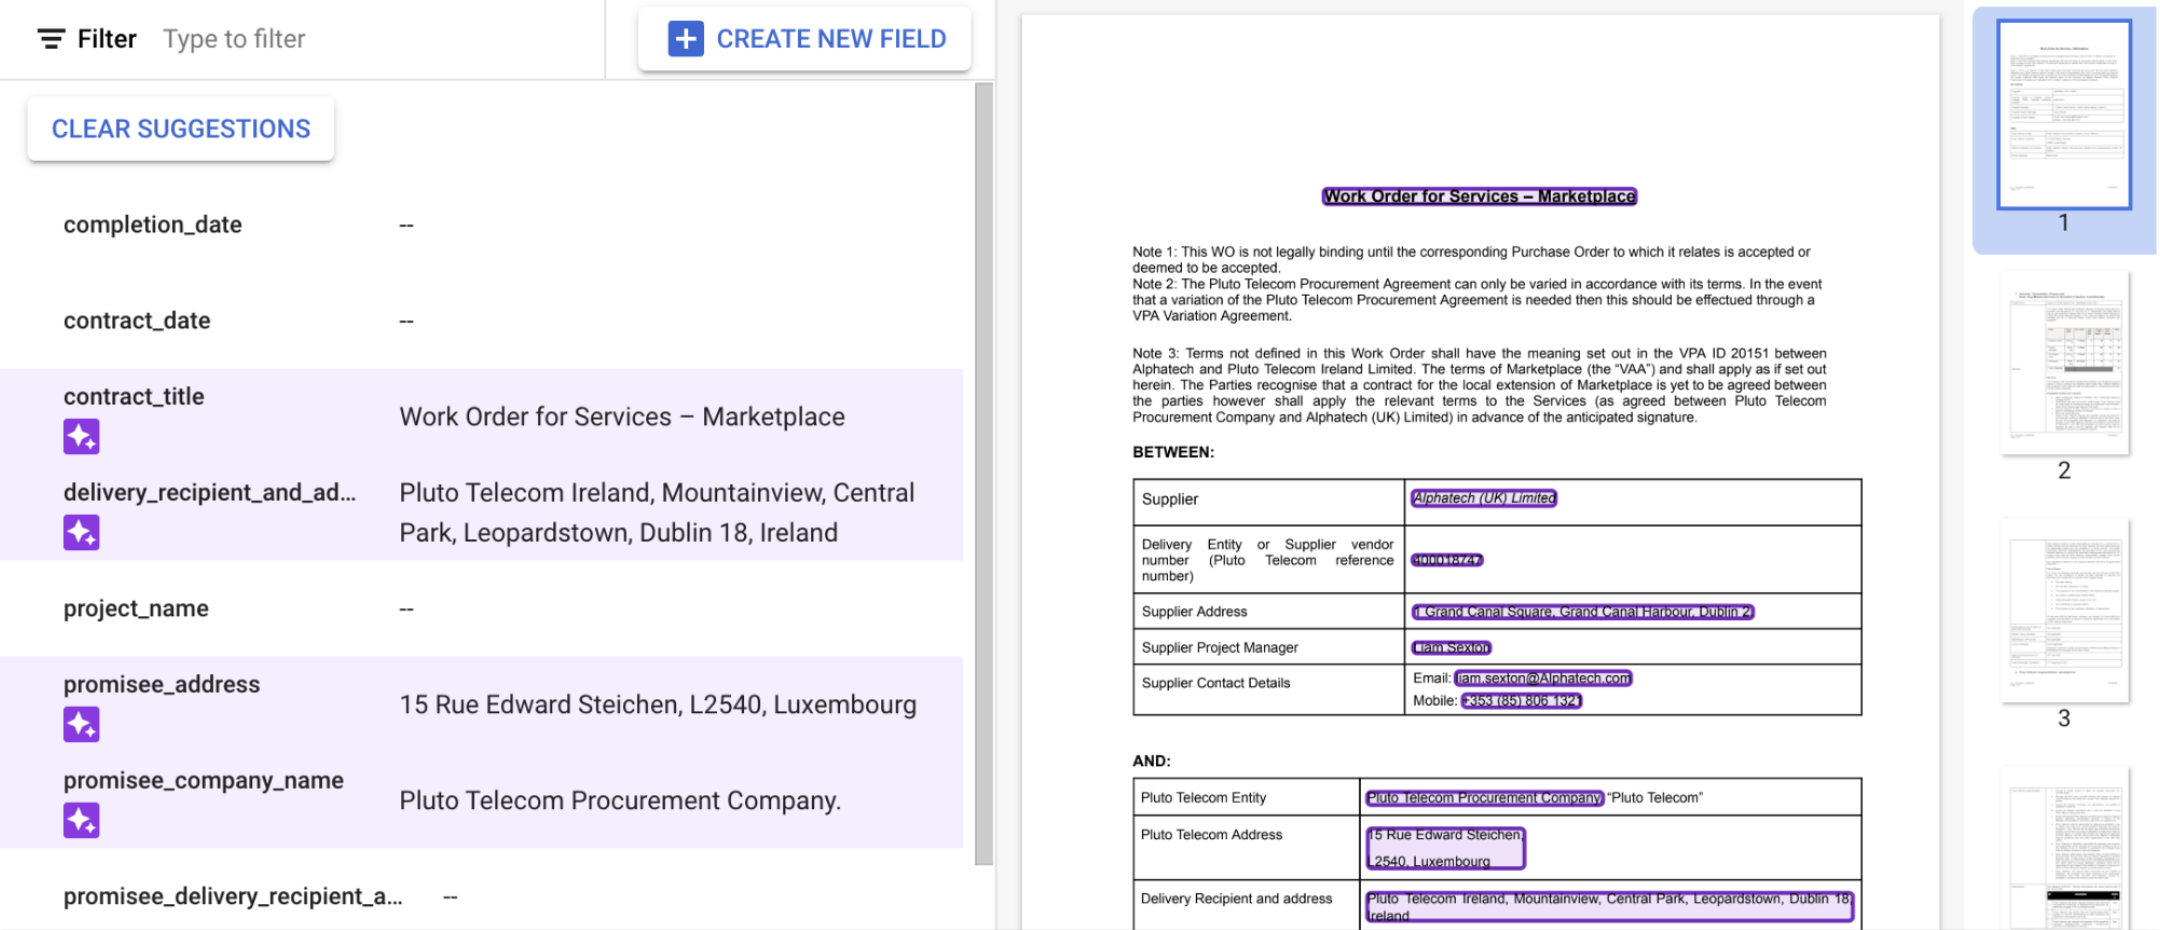

## 4. Review the results
## 5. Take a look at labelling
## 6. Deploy the model
(You can now access it through an API)

## Installation

Install the packages required for executing this notebook.

In [1]:
! pip3 install --upgrade --quiet google-cloud-storage \
                                 google-cloud-documentai==2.22.0 \
                                 google-cloud-core==1.6.0 \
                                 simplejson \
                                 kfp \
                                 google-cloud-aiplatform==1.27.0 \
                                 google-cloud-iam \
                                 tabulate
!pip3 install --upgrade google-auth

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.8.0 requires google-auth<3.0dev,>=2.15.0, but you have google-auth 1.35.0 which is incompatible.
google-ai-generativelanguage 0.6.4 requires google-auth!=2.24.0,!=2.25.0,<3.0.0dev,>=2.14.1, but you have google-auth 1.35.0 which is incompatible.
google-auth-oauthlib 1.2.0 requires google-auth>=2.15.0, but you have google-auth 1.35.0 which is incompatible.
google-cloud-bigquery-storage 2.25.0 requires google-auth<3.0.0dev,>=2.14.1, but you have google-auth 1.35.0 which is incompatible.
google-cloud-language 2.13.3 requires google-auth!=2.24.0,!=2.25.0,<3.0.0dev,>=2.14.1, but you have google-auth 1.35.0 which is incompatible.
google-colab 1.0.0 requires google-auth==2.27.0, but you have google-auth 1.35.0 which is incompatib

### Colab only: Uncomment the following cell to restart the kernel.

In [7]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager).

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Document AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [1]:
PROJECT_ID = "gen-ai-sandbox"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### LOCATION

You can also change the `LOCATION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
LOCATION = "us"  # @param {type: "string"}

# Use "us" or "eu"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
#from google.colab import auth
#auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = ""  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [3]:
SERVICE_ACCOUNT = ""  # @param {type:"string"}

In [6]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    if IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 230294883006-compute@developer.gserviceaccount.com


#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

No changes made to gs://ratecards-eval-gen-ai-sandbox-unique/
No changes made to gs://ratecards-eval-gen-ai-sandbox-unique/


### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [3]:
from google.cloud import documentai as docai
from google.cloud import storage

from google.cloud import aiplatform as aip
from google.api_core.client_options import ClientOptions

import os
import re
import pandas as pd
import kfp

from typing import Iterator, Optional, MutableSequence, Sequence, Tuple, cast
from tabulate import tabulate


# Initial Setup
#################

DATASET_ID = ""
destination_table = ""

mime_type ="application/pdf"
processor_display_name = ""
processor_id =""
PROCESSOR_ID = "PROCESSOR_ID"  # The processor you created in the Cloud Console


GCS_INPUT_BUCKET = 'cloud-samples-data'
GCS_INPUT_PREFIX = 'documentai/async_forms/'
GCS_OUTPUT_URI = 'YOUR-OUTPUT-BUCKET'
GCS_OUTPUT_URI_PREFIX = 'TEST'
TIMEOUT = 300

### List the Processors

In [9]:
document_ocr_display_name = "document-ocr"
form_parser_display_name = "form-parser"

test_processor_display_names_and_types = (
    (document_ocr_display_name, "OCR_PROCESSOR"),
    (form_parser_display_name, "FORM_PARSER_PROCESSOR"),
)

def get_client() -> docai.DocumentProcessorServiceClient:
    client_options = {"api_endpoint": f"{LOCATION}-documentai.googleapis.com"}
    return docai.DocumentProcessorServiceClient(client_options=client_options)

def get_parent(client: docai.DocumentProcessorServiceClient) -> str:
    return client.common_location_path(PROJECT_ID, LOCATION)

def get_client_and_parent() -> Tuple[docai.DocumentProcessorServiceClient, str]:
    client = get_client()
    parent = get_parent(client)
    return client, parent

def fetch_processor_types() -> MutableSequence[docai.ProcessorType]:
    # You must set the api_endpoint if you use a location other than 'us'.
    opts = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")

    client = docai.DocumentProcessorServiceClient(client_options=opts)

    # The full resource name of the location
    # e.g.: projects/project_id/locations/location
    parent = client.common_location_path(PROJECT_ID, LOCATION)

    # Fetch all processor types
    response = client.fetch_processor_types(parent=parent)

    print("Processor types:")
    # Print the available processor types
    return response.processor_types

def print_processor_types(processor_types: Sequence[docai.ProcessorType]):
    def sort_key(pt):
        return (not pt.allow_creation, pt.category, pt.type_)

    sorted_processor_types = processor_types # sorted(processor_types, key=sort_key)
    data = processor_type_tabular_data(sorted_processor_types)
    headers = next(data)
    colalign = next(data)

    print(tabulate(data, headers, tablefmt="pretty", colalign=colalign))
    print(f"→ Processor types: {len(sorted_processor_types)}")

def processor_type_tabular_data(
    processor_types: Sequence[docai.ProcessorType],
) -> Iterator[Tuple[str, str, str, str]]:
    def locations(pt):
        return ", ".join(sorted(loc.location_id for loc in pt.available_locations))

    yield ("type", "category", "allow_creation", "locations")
    yield ("left", "left", "left", "left")
    if not processor_types:
        yield ("-", "-", "-", "-")
        return
    for pt in processor_types:
        yield (pt.type_, pt.category, f"{pt.allow_creation}", locations(pt))

processor_types = fetch_processor_types()
print_processor_types(processor_types)

Processor types:
+--------------------------------------+-------------+----------------+-----------------------------------------------------------------------------------------------------------------+
| type                                 | category    | allow_creation | locations                                                                                                       |
+--------------------------------------+-------------+----------------+-----------------------------------------------------------------------------------------------------------------+
| INVOICE_PROCESSOR                    | SPECIALIZED | True           | asia-south1, asia-southeast1, australia-southeast1, eu, northamerica-northeast1, us                             |
| CUSTOM_EXTRACTION_PROCESSOR          | CUSTOM      | True           | asia-south1, asia-southeast1, australia-southeast1, eu, europe-west2, europe-west3, northamerica-northeast1, us |
| FORM_PARSER_PROCESSOR                | GENERAL     

## Listing the existing processors

In [10]:
def list_processors() -> MutableSequence[docai.Processor]:
    client, parent = get_client_and_parent()
    response = client.list_processors(parent=parent)

    return list(response.processors)

def print_processors(processors: Optional[Sequence[docai.Processor]] = None):
    def sort_key(processor):
        return processor.display_name

    if processors is None:
        processors = list_processors()
    sorted_processors = sorted(processors, key=sort_key)
    data = processor_tabular_data(sorted_processors)
    headers = next(data)
    colalign = next(data)

    print(tabulate(data, headers, tablefmt="pretty", colalign=colalign))
    print(f"→ Processors: {len(sorted_processors)}")

def processor_tabular_data(
    processors: Sequence[docai.Processor],
) -> Iterator[Tuple[str, str, str]]:
    yield ("display_name", "type", "state")
    yield ("left", "left", "left")
    if not processors:
        yield ("-", "-", "-")
        return
    for processor in processors:
        yield (processor.display_name, processor.type_, processor.state.name)

processors = list_processors()
print_processors(processors)

+-----------------------------+-----------------------------+----------+
| display_name                | type                        | state    |
+-----------------------------+-----------------------------+----------+
| custom-summariser           | SUMMARY_PROCESSOR           | DISABLED |
| deb-lee-test                | CUSTOM_EXTRACTION_PROCESSOR | ENABLED  |
| fake-edi-custom-processor-1 | CUSTOM_EXTRACTION_PROCESSOR | ENABLED  |
| genai-processor-demo        | CUSTOM_EXTRACTION_PROCESSOR | ENABLED  |
| new-still-fake-edi          | PURCHASE_ORDER_PROCESSOR    | ENABLED  |
| summariser                  | SUMMARY_PROCESSOR           | ENABLED  |
| test_layour_parser          | LAYOUT_PARSER_PROCESSOR     | DISABLED |
+-----------------------------+-----------------------------+----------+
→ Processors: 7


## Helper Function to select a Processor:

In [21]:
def get_processor(
    display_name: str,
    processors: Optional[Sequence[docai.Processor]] = None,
) -> Optional[docai.Processor]:
    if processors is None:
        processors = list_processors()
    for processor in processors:
        if processor.display_name == display_name:
            return processor
    return None

genai_processor_display_name = "TBC"

processor = get_processor(genai_processor_display_name, processors)

print(processor)

None


## Let's test the processor

Define helper functions to process files:

In [17]:
def process_file(
    processor: docai.Processor,
    file_path: str,
    mime_type: str,
) -> docai.Document:
    client = get_client()
    with open(file_path, "rb") as document_file:
        document_content = document_file.read()
    document = docai.RawDocument(content=document_content, mime_type=mime_type)
    request = docai.ProcessRequest(raw_document=document, name=processor.name)

    response = client.process_document(request)

    return response.document

In [18]:
## Helper function to use GCS

def docAI_process_doc(
        processor: docai.Processor,
        bucket_name: str,
        file_name: str,
        mime_type: str,
) -> docai.Document:
  docai_client = get_client()
  storage_client = storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_name)

  url = f"https://storage.cloud.google.com/{bucket_name}/{file_name}"

  with blob.open('rb') as f:
    doc_content = f.read()

  document = docai.RawDocument(content=doc_content, mime_type=mime_type)
  request = docai.ProcessRequest(raw_document=document, name=processor.name)
  response = docai_client.process_document(request)
  data = []
  for entity in response.document.entities:
      data = append_to_data(data,entity)

def append_to_data(dict,entity):
  if entity.mention_text:
    dict.append([entity.type, entity.mention_text, entity.confidence])
    print(entity.type + ": " + entity.mention_text)
  else:
    for subentity in entity.properties:
      dict = append_to_data(dict,subentity)
  return dict

In [19]:
file_path = "./Sample-SoW.pdf"
mime_type = "application/pdf"

document = process_file(processor, file_path, mime_type)

In [20]:
data = []
header = ["field_name", "extracted_value", "confidence"]

for entity in document.entities:
    data.append([entity.type,entity.mention_text,entity.confidence])

print(tabulate(data, header, tablefmt="simple", disable_numparse=True))

field_name                        extracted_value                                               confidence
--------------------------------  ------------------------------------------------------------  ------------
promisee_address                  15 Rue Edward Steichen,                                       1.0
                                  L2540, Luxembourg
promisee_point_of_contact_name    Fiona Smyth                                                   1.0
project_name                      Project 20 - Requirement to Update Discount IDs               1.0
contract_title                    Work Order for IT Professional Service                        1.0
promisee_company_name             Pluto Telecom Procurement Company.                            1.0
promisor_vendor_number            400018747                                                     1.0
promisor_company_name             Alphatech (UK) Limited                                        1.0
promisor_address                